In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from torch import autograd
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fastai.torch_imports import *
from pathlib import Path
from itertools import repeat
import tensorboardX
torch.cuda.set_device(2)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True


/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
uid = 'bw2color'
D_MODEL_SAVE_PATH = DATA_PATH/(uid + '_230_D.h5')
G_MODEL_SAVE_PATH = DATA_PATH/(uid + '_230_G.h5')
#keep_pct=0.02
keep_pct=1.0
#keep_pct=0.005
#keep_pct=1.0

In [4]:
def get_model_data(image_size: int, batch_size: int, keep_pct: float):
    TRAIN_X_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=True, size=image_size, uid=uid)
    TRAIN_Y_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=False, size=image_size, uid=uid)
    x_paths, y_paths = get_matched_xy_file_lists(TRAIN_X_PATH, TRAIN_Y_PATH)
    x_paths_str = convert_paths_to_str(x_paths)
    y_paths_str = convert_paths_to_str(y_paths)
    print(x_paths_str[:5])
    print(y_paths_str[:5])
    np.random.seed(42)
    keeps = np.random.rand(len(x_paths_str)) < keep_pct
    fnames_x = np.array(x_paths_str, copy=False)[keeps]
    fnames_y = np.array(y_paths_str, copy=False)[keeps]
    val_idxs = get_cv_idxs(len(fnames_x), val_pct=min(0.01/keep_pct, 0.1))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames_x), np.array(fnames_y))
    img_fn = TRAIN_Y_PATH/'n01558993'/'n01558993_9684.JPEG'
    tfms = tfms_from_stats(inception_stats, image_size, tfm_y=TfmType.PIXEL, aug_tfms=transforms_side_on, sz_y=image_size)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=TRAIN_Y_PATH.parent)
    md = ImageData(DATA_PATH, datasets, batch_size, num_workers=16, classes=None)
    return md

In [5]:
md = get_model_data(image_size=224, batch_size=128, keep_pct=keep_pct)
denorm = md.val_ds.denorm

['train_x_bw2color_224/n01440764/n01440764_10026.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10027.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10029.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10040.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10042.JPEG']
['train_y_bw2color_224/n01440764/n01440764_10026.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10027.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10029.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10040.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10042.JPEG']


In [6]:
def generate_denormed_image_pairs(ds: FilesDataset, batches: [(ndarray,ndarray)], idx:int = 0):
    return [(ds.denorm(x)[idx], ds.denorm(y)[idx])for (x,y) in batches]

## EDSR Model

##### TODO:  Also try making the loss/output based on "classification" like in Zhang et al.
##### TODO:  After making unet version- plug that into a Weiserman GAN setup (the discrimator looks at grey image and colorized image, concatenated together via channels).
##### TODO:  Try using higher res images (from FloydHub blog?)
##### TODO:  Try perceptual loss again....
##### TODO:  To convert real old photos, could force them to normal grayscale first.
##### TODO:  Add tensorboard graphs

In [7]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [8]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def remove(self): 
        self.hook.remove()

In [9]:
class FeatureLoss(nn.Module):
    def __init__(self, block_wgts: [float] = [0.2,0.7,0.1]):
        super().__init__()
        m_vgg = vgg16(True)
        
        blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
        blocks, [m_vgg[i] for i in blocks]
        layer_ids = blocks[:3]
        
        vgg_layers = children(m_vgg)[:23]
        m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
        set_trainable(m_vgg, False)
        
        self.m,self.wgts = m_vgg,block_wgts
        self.sfs = [SaveFeatures(m_vgg[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(self.flatten(inp.features),self.flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def flatten(self, x): 
        return x.view(x.size(0), -1)
    
    def close(self):
        for o in self.sfs: o.remove()

In [10]:
def conv(ni, nf, kernel_size=3, actn=False, stride=1, normalizer=None):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2, stride=stride)]
    if normalizer is not None: layers.append(normalizer)
    if actn: layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

In [11]:
class UpSampleBlock(nn.Module):
    def __init__(self, ni, nf, scale=2):
        super().__init__()
        layers = []
        for i in range(int(math.log(scale,2))):
            layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
        self.sequence = nn.Sequential(*layers)
        self.icnr_init()
        
    def icnr_init(self):
        conv_shuffle = self.sequence[0][0]
        kernel = icnr(conv_shuffle.weight)
        conv_shuffle.weight.data.copy_(kernel);
    
    def forward(self, x):
        return self.sequence(x)

In [12]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x + self.m(x) * self.res_scale

In [13]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf, actn=True), conv(nf, nf)], 0.1)

In [14]:
class ImageModifierModel(nn.Module):
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut

    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
    
    def __init__(self, nf_up=32, nf_mid=64):
        super().__init__() 
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256,nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        
        mid_layers = []
        mid_layers += [conv(nf_up * 4,nf_mid), nn.BatchNorm2d(nf_mid)]
        for i in range(8): mid_layers.append(res_block(nf_mid))
        mid_layers += [nn.BatchNorm2d(nf_mid), conv(nf_mid, 3, kernel_size=1)]
        self.upconv = nn.Sequential(*mid_layers)
             
        out_layers = []
        out_layers += [conv(6, 3, kernel_size=1)]
        self.out = nn.Sequential(*out_layers)
        
    def forward(self, x): 
        self.rn(x)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        x5 = self.upconv(torch.cat([x1, x2, x3, x4], dim=1))
        #x5 = self.upconv(torch.cat([x2, x3, x4], dim=1))
        return F.tanh(self.out(torch.cat([x, x5], dim=1)))

## WGAN Critic Model

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()   
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [16]:
class Critic(nn.Module):
    
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
    
    def __init__(self, size, nf_up, nf_mid):
        super().__init__()
 
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256,nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        
        self.raw_up = nn.Sequential(*[conv(3, nf_up)])
        
        mid_layers = []
        #mid_layers += [conv(nf_up*10,nf_mid), nn.BatchNorm2d(nf_mid)]
        mid_layers += [conv(nf_up*10,nf_mid)]
        for i in range(4): mid_layers.append(res_block(nf_mid))
        #mid_layers += [nn.BatchNorm2d(nf_mid), conv(nf_mid, nf_mid)]
        mid_layers += [conv(nf_mid, nf_mid)]
        self.upconv = nn.Sequential(*mid_layers)
        
        
        pyr_layers = []
        csize = size
        cndf = nf_mid
        
        while csize > 8:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2, bn=False))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)
        
    def forward(self, input, orig):
        self.rn(orig)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        orig_features =  torch.cat([x1, x2, x3, x4], dim=1)
        
        self.rn(input)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        result_features = torch.cat([x1, x2, x3, x4], dim=1)
        
        orig_up = self.raw_up(orig)
        input_up = self.raw_up(orig)
        
        combined_features = torch.cat([orig_up, input_up, orig_features, result_features], dim=1)      
        x = self.upconv(combined_features)
        x = self.pyramid(x)
        return self.final(x).mean()

In [17]:
class Critic2(nn.Module):
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
            
    def __init__(self, nf_up, nf_mid, sz):
        super().__init__()
         
        self.nf_mid = nf_mid
        self.nf_up = nf_up
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(self.rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256,nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        self.raw_up = nn.Sequential(*[conv(3, nf_up, kernel_size=1, actn=False)])
        
        self.mid = nn.Sequential(
            nn.LayerNorm([nf_up*8 + 6, sz, sz]),
            nn.Conv2d(nf_up*8 + 6, nf_mid, 3, 2, padding=1),
            nn.LayerNorm([nf_mid, sz//2, sz//2]),
            nn.LeakyReLU(),
            nn.Conv2d(nf_mid, 2 * nf_mid, 3, 2, padding=1),
            nn.LayerNorm([2 * nf_mid, sz//4, sz//4]),
            nn.LeakyReLU(),
            nn.Conv2d(2 * nf_mid, 4 * nf_mid, 3, 2, padding=1),
            nn.LayerNorm([4 * nf_mid, sz//8, sz//8]),
            nn.LeakyReLU(),
            nn.Conv2d(4 * nf_mid, 8 * nf_mid, 3, 2, padding=1),
            nn.LayerNorm([8 * nf_mid, sz//16, sz//16]),
            nn.LeakyReLU()
        )
        

        self.out = nn.Sequential(
            nn.Conv2d(8 * nf_mid, 1, 4, padding=2)
        )
        
    def forward(self, input, orig):
        self.rn(orig)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        orig_features =  torch.cat([x1, x2, x3, x4], dim=1)
        
        self.rn(input)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        result_features = torch.cat([x1, x2, x3, x4], dim=1)
              
        combined_features = torch.cat([orig, input, orig_features, result_features], dim=1)      
        x = self.mid(combined_features)
        x = self.out(x)
        return x.mean()

In [18]:
class Critic3(nn.Module):
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    @staticmethod
    def generate_residual_block(nf):
        
        return ResSequential(
            [conv(nf, nf, actn=True), 
             conv(nf, nf, actn=True), 
             conv(nf, nf)])
    
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
            
    def __init__(self, nf_up, nf_mid):
        super().__init__()
         
        self.nf_mid = nf_mid
        self.nf_up = nf_up
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(self.rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256,nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        
        mid_layers = [] 
        mid_layers.append(conv(nf_up*8 + 6, nf_mid, kernel_size=1, actn=False))
        
        for i in range(8):
            mid_layers.append(Critic3.generate_residual_block(nf_mid))
            
        self.mid = nn.Sequential(*mid_layers)

        self.out = nn.Sequential(
            nn.Conv2d(nf_mid, 1, 4, padding=2)
        )
        
    def forward(self, input, orig):
        self.rn(orig)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        orig_features =  torch.cat([x1, x2, x3, x4], dim=1)
        
        self.rn(input)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        result_features = torch.cat([x1, x2, x3, x4], dim=1)
             
        x = torch.cat([orig, input, orig_features, result_features], dim=1)      
        x = self.mid(x)
        x = self.out(x)
        return x.mean()

In [19]:
class Critic4(nn.Module):
    @staticmethod
    def generate_residual_block(nf):
        return ResSequential(
            [conv(nf, nf, actn=True), 
             conv(nf, nf, actn=True), 
             conv(nf, nf)])
    
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
            
    def __init__(self, nf):
        super().__init__()
     
        self.mid = nn.Sequential(
            nn.Conv2d(6, nf, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(nf, 2 * nf, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * nf, 4 * nf, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(4 * nf, 8 * nf, 3, 2, padding=1),
            nn.LeakyReLU()
        )

        self.out = nn.Sequential(
            nn.Conv2d(8 * nf, 1, 4, padding=2)
        )
        
    def forward(self, input, orig):      
        x = torch.cat([orig, input], dim=1)      
        x = self.mid(x)
        x = self.out(x)
        return x.mean()

## Training

In [20]:
#def train(lrs, session_num: int, cycle_len=2, use_clr_beta=(20,10,0.95,0.85)):
#    if session_num > 0:
#        learn.load(uid + '_224_' + str(session_num - 1))
#    learn.fit(lrs, 1, cycle_len=cycle_len, wds=wd, use_clr_beta=use_clr_beta)
#    learn.save(uid + '_224_' + str(session_num))

In [21]:
def visualize(md: ImageData, model: nn.Module, start_idx: int, count: int, figsize=(20,20), max_columns=4):
    end_index = start_idx + count
    idxs = list(range(start_idx,end_index))
    #plot_image_outputs_from_model(md.val_ds, model, list(range(start_idx,end_index)), figsize=figsize, max_columns=max_columns)
    
    image_pairs = []
    ds = md.val_ds

    for idx in idxs:
        x,_=ds[idx]
        preds = model(VV(x[None]))
        image_pairs.append((ds.denorm(x[None])[0], ds.denorm(preds)[0]))
        
    num_pairs = len(image_pairs)
    num_images = num_pairs * 2
    rows, columns = get_num_rows_columns(num_images, max_columns)

    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    for i,(x,y) in enumerate(image_pairs):
        plot_image_from_ndarray(x, axes=axes.flat[i*2])
        plot_image_from_ndarray(y, axes=axes.flat[i*2+1])
        
    display(fig)

In [22]:
wd=1e-7
bs = 16
sz = 128
md = get_model_data(image_size=sz, batch_size=bs, keep_pct=keep_pct)

netG = ImageModifierModel(nf_up=32, nf_mid=64).cuda()
#load_model(netG, G_MODEL_SAVE_PATH)
netD = Critic2(32, 128, sz).cuda()
#load_model(netD, D_MODEL_SAVE_PATH)

['train_x_bw2color_128/n01440764/n01440764_10026.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10027.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10029.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10040.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10042.JPEG']
['train_y_bw2color_128/n01440764/n01440764_10026.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10027.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10029.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10040.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10042.JPEG']


/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is no

In [23]:
#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-4)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-4)

#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-3)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-3)

#TODO:  Weird beta 1 value, but we'll see...

optimizerD = optim.Adam(filter(lambda p: p.requires_grad,netD.parameters()), lr=1e-3, betas=(0., 0.9), eps=1e-5)
optimizerG = optim.Adam(filter(lambda p: p.requires_grad,netG.parameters()), lr=1e-3, betas=(0., 0.9), eps=1e-5)

In [24]:
def calc_gradient_penalty(netD, real_data, fake_data, orig_data):
    lamda = 10 # Gradient penalty lambda hyperparameter
    # print "real_data: ", real_data.size(), fake_data.size()
    alpha = torch.rand(bs, 1)
    alpha = alpha.expand(bs, real_data.nelement()//bs).contiguous().view(bs, 3, sz, sz)
    alpha = alpha.cuda()
    differences = fake_data - real_data
    interpolates = real_data + (alpha*differences)
    interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates, orig_data)
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lamda
    return gradient_penalty

In [25]:
def update_learning_rate(optimizer, i, n, start_lr):
    for param_group in optimizer.param_groups:
        lr = (n-i)/n * start_lr
        param_group['lr'] = lr

def progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, equilibrium):
    equilibrium_str = 'Y' if equilibrium else 'N'
    
    if i % 50 == 0 or equilibrium:
        print(f'\nWDist {to_np(w_dist)}; GPenalty {to_np(gradient_penalty)}; RScore {to_np(disc_real)};'
          + f' FScore {to_np(disc_fake)}; Equilibrium? {equilibrium_str}')

    if i % 500 == 0:
        visualize(md, netG, 500, 8)
        save_model(netD, D_MODEL_SAVE_PATH)
        save_model(netG, G_MODEL_SAVE_PATH)
    

def train(niter, first=True):
    start_lr_d = optimizerD.param_groups[0]['lr']
    start_lr_g = optimizerG.param_groups[0]['lr']
    
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        n = n-(n%bs)
        with tqdm(total=n) as pbar:
            while i < n:
                netD.set_trainable(True)
                netG.set_trainable(False)
                #d_iters = 300 if (first and (gen_iterations < 50) or (gen_iterations % 1000 == 0)) else 15
                #d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 25
                #d_iters = 1000 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 50
                j = 0
                equilibrium = False
                while (not equilibrium) and (i < n) and j<10000:
                    j += 1; i += 1
                    #or p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    x, y = next(data_iter)
                    orig_image = V(x)
                    real_image = V(y)                        
                    #Higher == Real
                    disc_real = netD(real_image, orig_image)
                    fake_image = netG(orig_image)
                    disc_fake = netD(V(fake_image.data), orig_image)
                    equilibrium = abs(disc_real + disc_fake) < (abs(disc_real) + abs(disc_fake))*0.05
                    
                    netD.zero_grad()
                          
                    gradient_penalty = calc_gradient_penalty(netD, real_image.data, fake_image.data, orig_image)              
                    disc_cost = disc_fake - disc_real + gradient_penalty
                    w_dist = disc_fake - disc_real
                    disc_cost.backward()
                    optimizerD.step()
                    update_learning_rate(optimizerD, i, n, start_lr_d)
                    pbar.update()
             
                    progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, equilibrium)

                    
                netD.set_trainable(False)
                netG.set_trainable(True)
                netG.zero_grad()
                
                x, y = next(data_iter)
                orig_image = V(x)
                real_image = V(y)   
                fake_image = netG(orig_image)
                gen_mse_cost = F.mse_loss(fake_image, real_image)
                gen_cost  = -netD(fake_image, orig_image)
                gen_cost .backward()
                optimizerG.step()
                update_learning_rate(optimizerD, i, n, start_lr_d)
                update_learning_rate(optimizerG, i, n, start_lr_g)
                gen_iterations += 1
                
                progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, False)

In [26]:
torch.backends.cudnn.benchmark=True

  0%|          | 50/79264 [00:36<14:41:03,  1.50it/s]
WDist -15.016841888427734; GPenalty 2.3712427616119385; RScore -27.444225311279297; FScore -42.46106719970703; Equilibrium? N
  0%|          | 100/79264 [01:09<14:43:12,  1.49it/s]
WDist -315.4581298828125; GPenalty 18.783367156982422; RScore -57.33077621459961; FScore -372.7889099121094; Equilibrium? N
  0%|          | 150/79264 [01:43<14:45:59,  1.49it/s]
WDist -610.1714477539062; GPenalty 22.723861694335938; RScore -117.60980987548828; FScore -727.78125; Equilibrium? N
  0%|          | 200/79264 [02:18<14:45:11,  1.49it/s]
WDist -1091.9755859375; GPenalty 17.365314483642578; RScore 29.969970703125; FScore -1062.005615234375; Equilibrium? N
  0%|          | 250/79264 [02:51<14:43:43,  1.49it/s]
WDist -1676.6549072265625; GPenalty 63.182254791259766; RScore 142.48899841308594; FScore -1534.1658935546875; Equilibrium? N
  0%|          | 300/79264 [03:25<14:45:18,  1.49it/s]
WDist -2366.84521484375; GPenalty 311.239501953125; RScore 

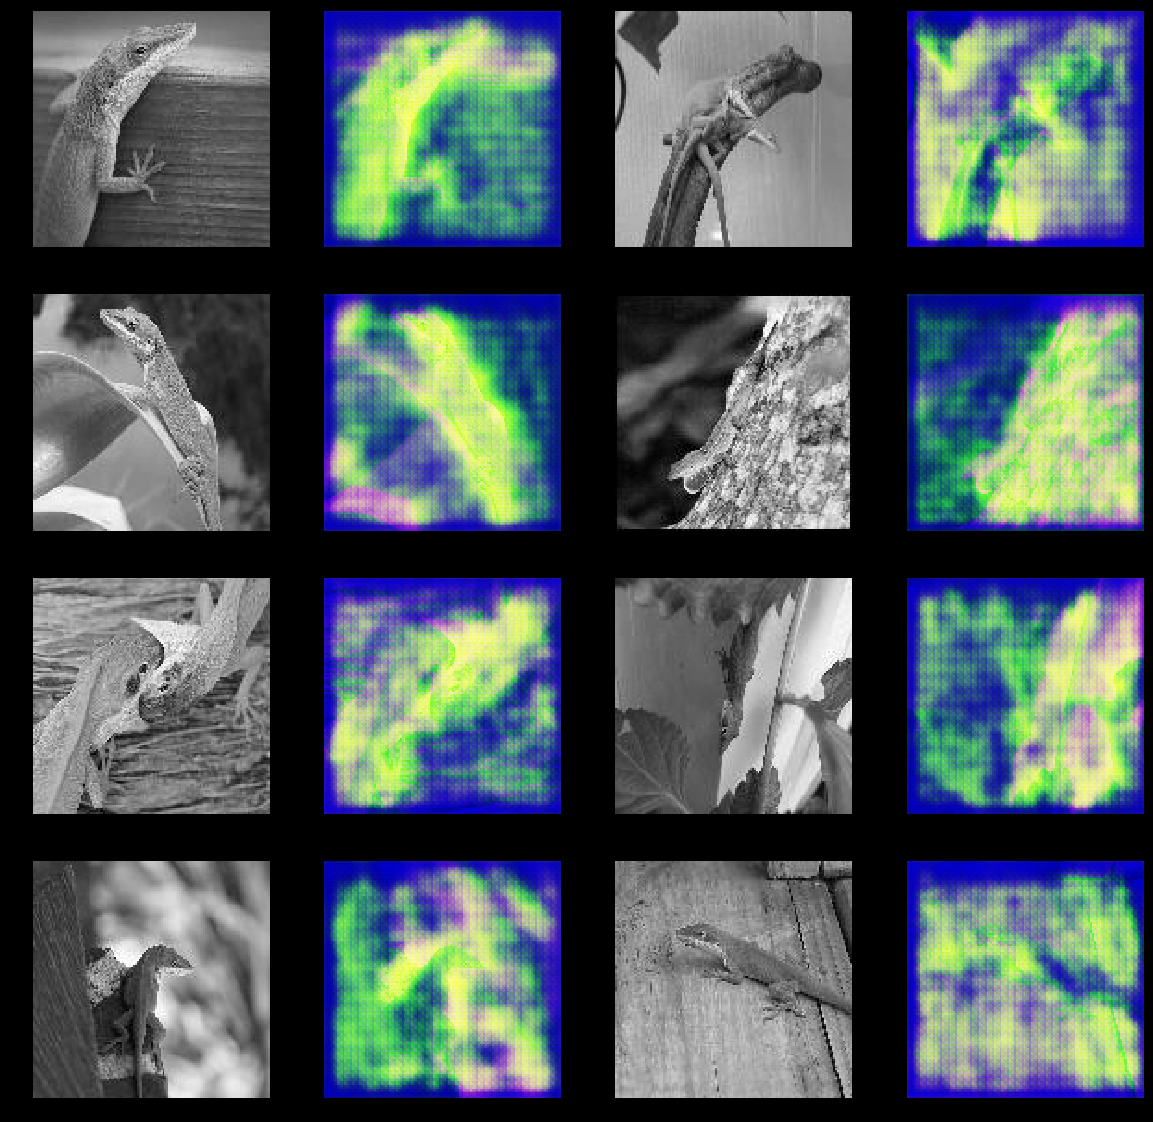

  1%|          | 526/79264 [06:12<14:44:09,  1.48it/s]
WDist -6055.53369140625; GPenalty 977.6796875; RScore 3168.671142578125; FScore -2886.862548828125; Equilibrium? Y
  1%|          | 539/79264 [06:21<14:44:13,  1.48it/s]
WDist -4432.4892578125; GPenalty 1171.7003173828125; RScore 2229.3369140625; FScore -2203.152099609375; Equilibrium? Y
  1%|          | 550/79264 [06:29<14:44:03,  1.48it/s]
WDist -88.5869140625; GPenalty 2.637157678604126; RScore 4472.31005859375; FScore 4383.72314453125; Equilibrium? N
  1%|          | 580/79264 [06:49<14:43:21,  1.48it/s]
WDist -5849.6005859375; GPenalty 1502.3084716796875; RScore 2969.10205078125; FScore -2880.498779296875; Equilibrium? Y
  1%|          | 599/79264 [07:02<14:43:22,  1.48it/s]
WDist -6012.9765625; GPenalty 1413.78857421875; RScore 3025.2255859375; FScore -2987.750732421875; Equilibrium? Y
  1%|          | 600/79264 [07:03<16:26:06,  1.33it/s]
WDist -6.2958984375; GPenalty 498.0137939453125; RScore 4506.07080078125; FScore 4499.7

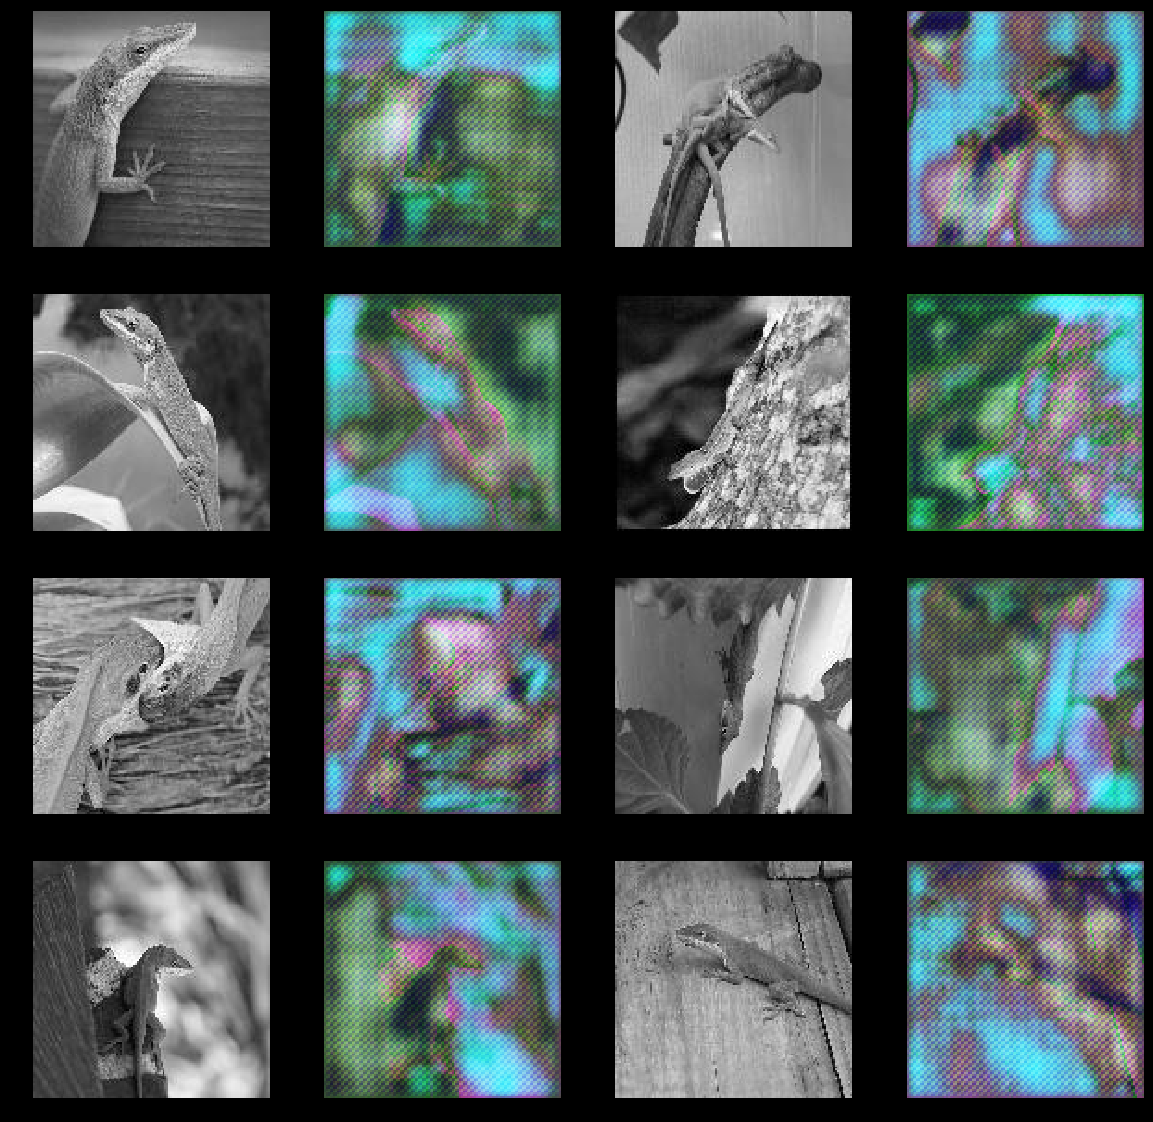

  1%|▏         | 1016/79264 [11:56<14:41:01,  1.48it/s]
WDist -8842.37109375; GPenalty 1564.78173828125; RScore 4422.482421875; FScore -4419.88916015625; Equilibrium? Y
  1%|▏         | 1047/79264 [12:17<14:39:09,  1.48it/s]
WDist -12049.3984375; GPenalty 2357.641845703125; RScore 6251.9521484375; FScore -5797.44580078125; Equilibrium? Y
  1%|▏         | 1050/79264 [12:19<15:27:09,  1.41it/s]
WDist -5572.8193359375; GPenalty 2593.190673828125; RScore 4219.04541015625; FScore -1353.773681640625; Equilibrium? N
  1%|▏         | 1058/79264 [12:25<14:39:08,  1.48it/s]
WDist -11303.216796875; GPenalty 3220.687255859375; RScore 5768.92626953125; FScore -5534.291015625; Equilibrium? Y
  1%|▏         | 1066/79264 [12:30<14:46:44,  1.47it/s]
WDist -8641.244140625; GPenalty 2671.823486328125; RScore 4327.51171875; FScore -4313.73291015625; Equilibrium? Y
  1%|▏         | 1100/79264 [12:55<14:38:32,  1.48it/s]
WDist -14869.8916015625; GPenalty 8953.7900390625; RScore 8826.98828125; FScore -6042.9

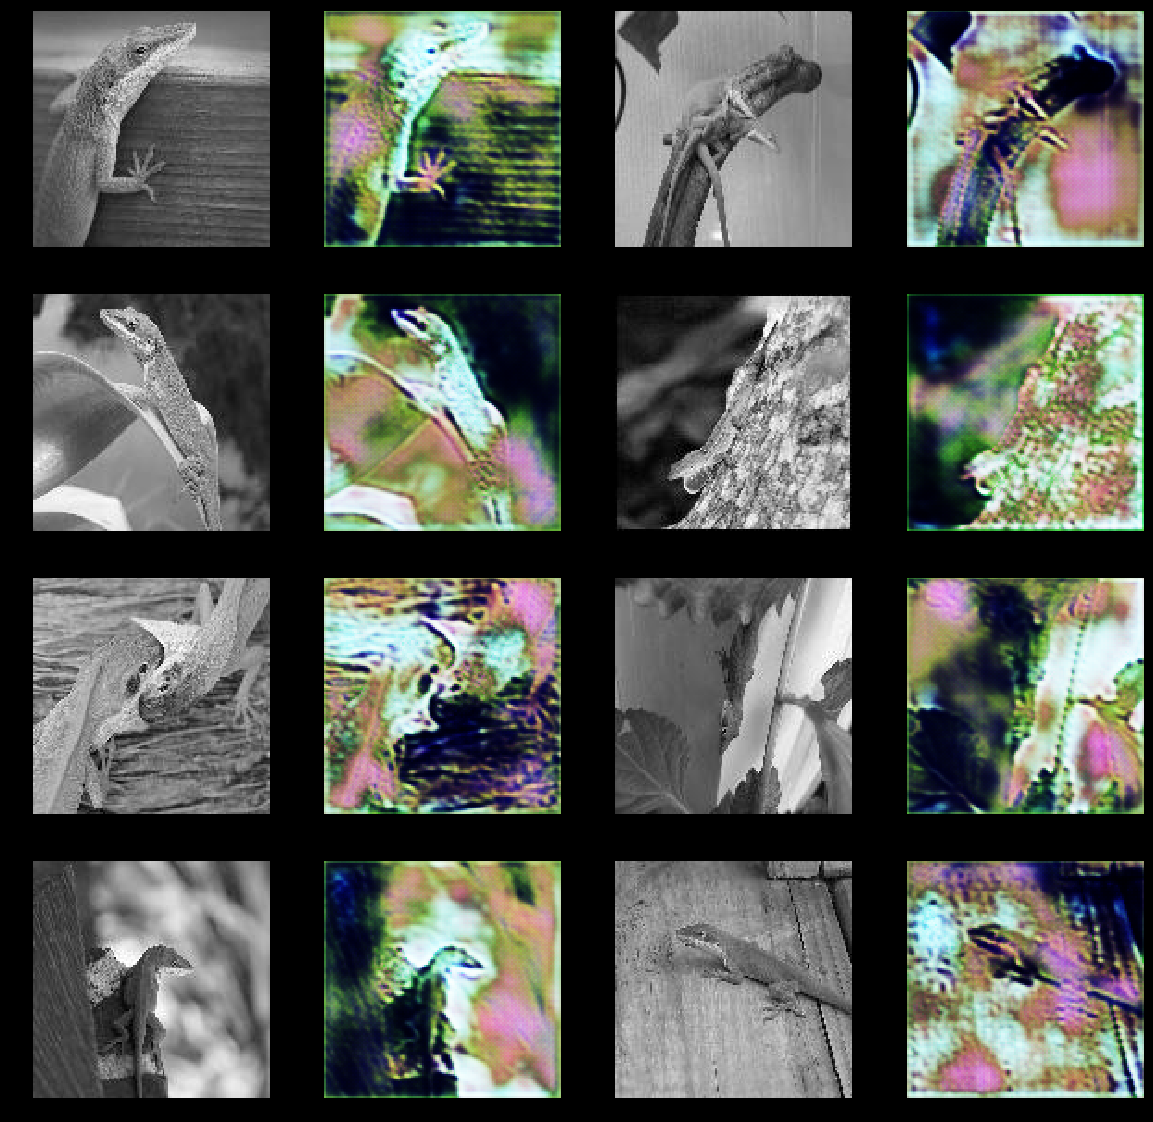

  2%|▏         | 1550/79264 [18:31<14:37:14,  1.48it/s]
WDist -17560.17578125; GPenalty 6522.265625; RScore 6248.11181640625; FScore -11312.064453125; Equilibrium? N
  2%|▏         | 1554/79264 [18:34<14:33:49,  1.48it/s]
WDist -20180.2578125; GPenalty 6865.83447265625; RScore 9588.4697265625; FScore -10591.7890625; Equilibrium? Y
  2%|▏         | 1573/79264 [18:47<14:34:25,  1.48it/s]
WDist -19247.390625; GPenalty 5604.82373046875; RScore 9468.48046875; FScore -9778.91015625; Equilibrium? Y
  2%|▏         | 1600/79264 [19:05<14:32:44,  1.48it/s]
WDist -15350.431640625; GPenalty 4385.919921875; RScore 4217.58154296875; FScore -11132.8505859375; Equilibrium? N
  2%|▏         | 1611/79264 [19:13<14:30:13,  1.49it/s]
WDist -20087.91796875; GPenalty 5208.8544921875; RScore 10457.7373046875; FScore -9630.181640625; Equilibrium? Y
  2%|▏         | 1648/79264 [19:38<14:32:51,  1.48it/s]
WDist -20466.9609375; GPenalty 4104.2041015625; RScore 9840.6103515625; FScore -10626.3515625; Equilibrium?

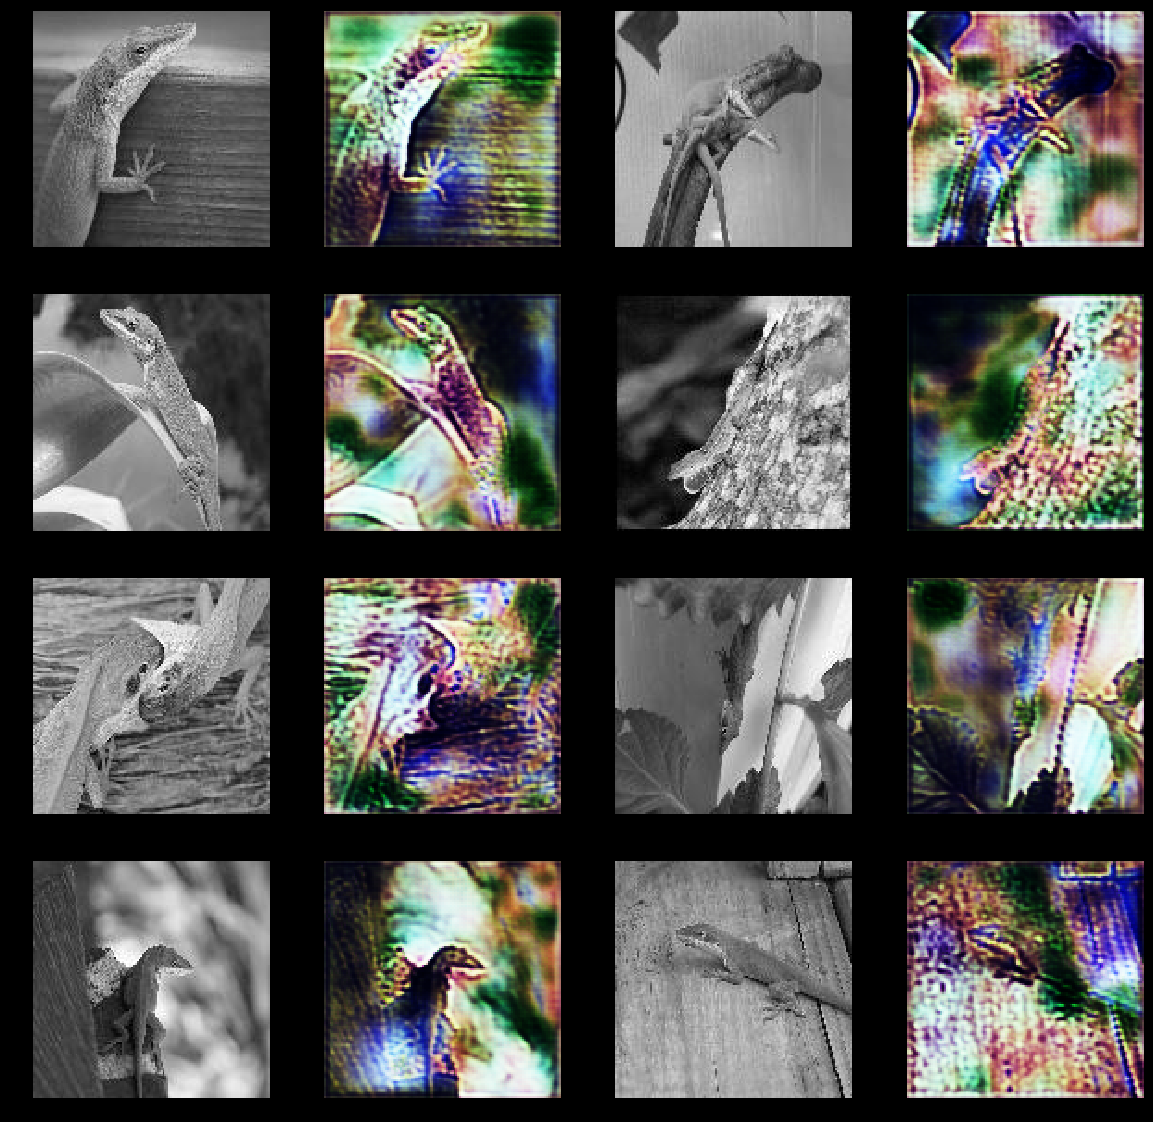

  3%|▎         | 2003/79264 [23:49<25:38:10,  1.19s/it]
WDist -23851.25; GPenalty 7951.03466796875; RScore 12316.8193359375; FScore -11534.431640625; Equilibrium? Y
  3%|▎         | 2014/79264 [23:57<14:43:10,  1.46it/s]
WDist -19456.32421875; GPenalty 6653.14501953125; RScore 10102.61328125; FScore -9353.7119140625; Equilibrium? Y
  3%|▎         | 2016/79264 [23:59<15:46:01,  1.36it/s]
WDist -21567.91796875; GPenalty 6177.6025390625; RScore 10442.8037109375; FScore -11125.11328125; Equilibrium? Y
  3%|▎         | 2030/79264 [24:08<14:29:56,  1.48it/s]
WDist -24065.05078125; GPenalty 12372.9775390625; RScore 11495.0439453125; FScore -12570.005859375; Equilibrium? Y
  3%|▎         | 2050/79264 [24:22<14:26:37,  1.48it/s]
WDist -14101.890625; GPenalty 4961.46728515625; RScore 15695.4609375; FScore 1593.570556640625; Equilibrium? N
  3%|▎         | 2056/79264 [24:26<14:26:17,  1.49it/s]
WDist -23378.04296875; GPenalty 15471.451171875; RScore 11217.640625; FScore -12160.4013671875; Equilib

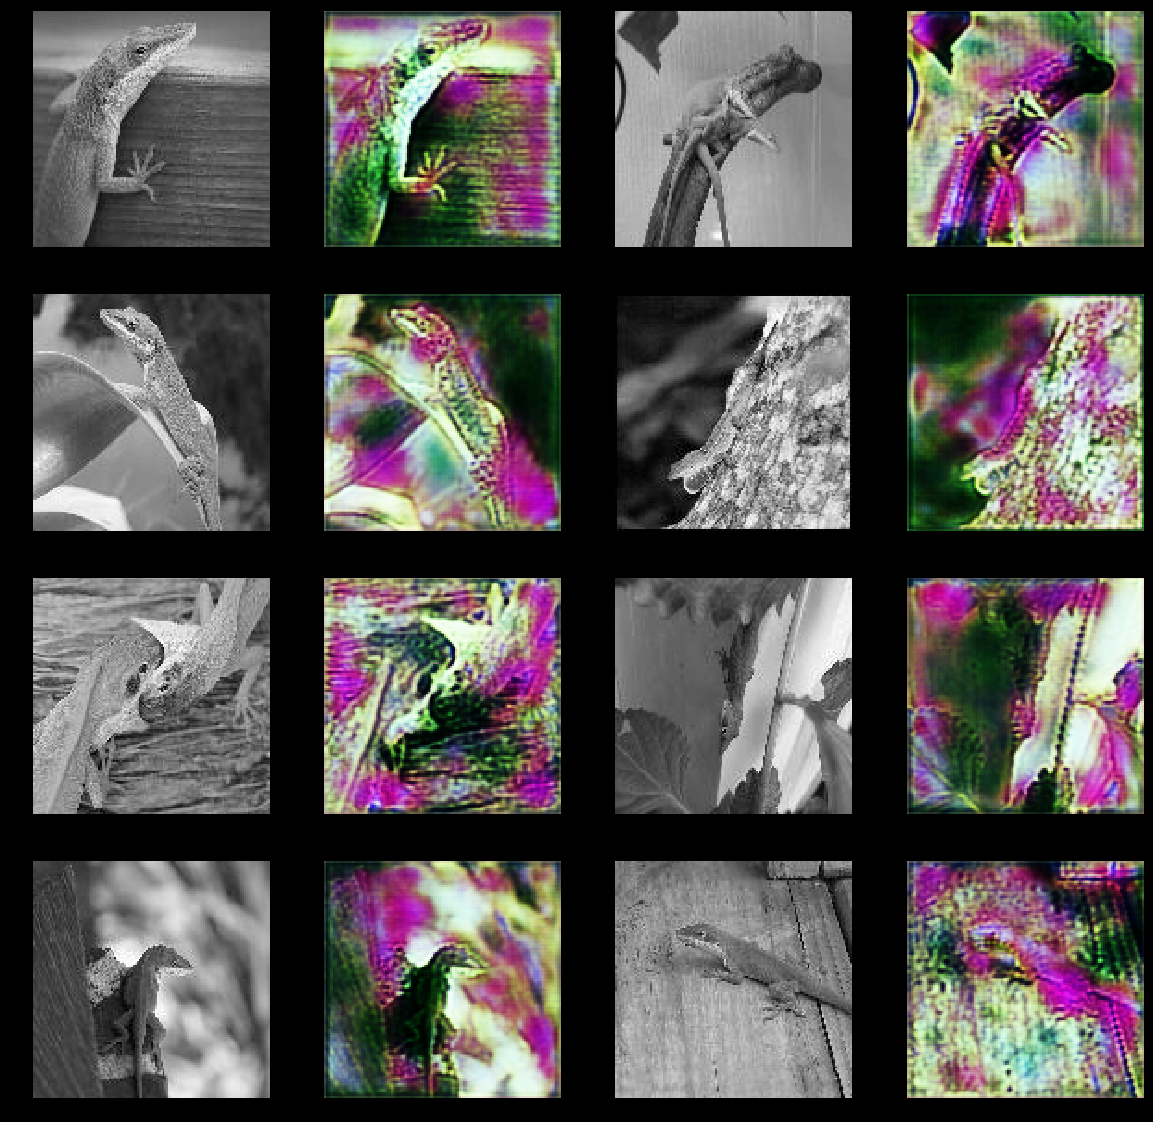

  3%|▎         | 2502/79264 [29:39<25:52:35,  1.21s/it]
WDist -27888.3125; GPenalty 9926.4326171875; RScore 14317.373046875; FScore -13570.9384765625; Equilibrium? Y
  3%|▎         | 2550/79264 [30:12<14:23:31,  1.48it/s]
WDist -19451.01953125; GPenalty 6646.025390625; RScore 284.7803649902344; FScore -19166.23828125; Equilibrium? N
  3%|▎         | 2594/79264 [30:42<14:25:30,  1.48it/s]
WDist -31497.78515625; GPenalty 10386.3828125; RScore 15093.4599609375; FScore -16404.326171875; Equilibrium? Y
  3%|▎         | 2600/79264 [30:46<14:41:04,  1.45it/s]
WDist -14206.23828125; GPenalty 4137.826171875; RScore -4213.646484375; FScore -18419.884765625; Equilibrium? N
  3%|▎         | 2619/79264 [31:00<14:26:20,  1.47it/s]
WDist -23766.826171875; GPenalty 11277.5498046875; RScore 12237.791015625; FScore -11529.03515625; Equilibrium? Y
  3%|▎         | 2650/79264 [31:21<14:21:22,  1.48it/s]
WDist -10452.8603515625; GPenalty 3396.2841796875; RScore -14731.4365234375; FScore -25184.296875; Equi

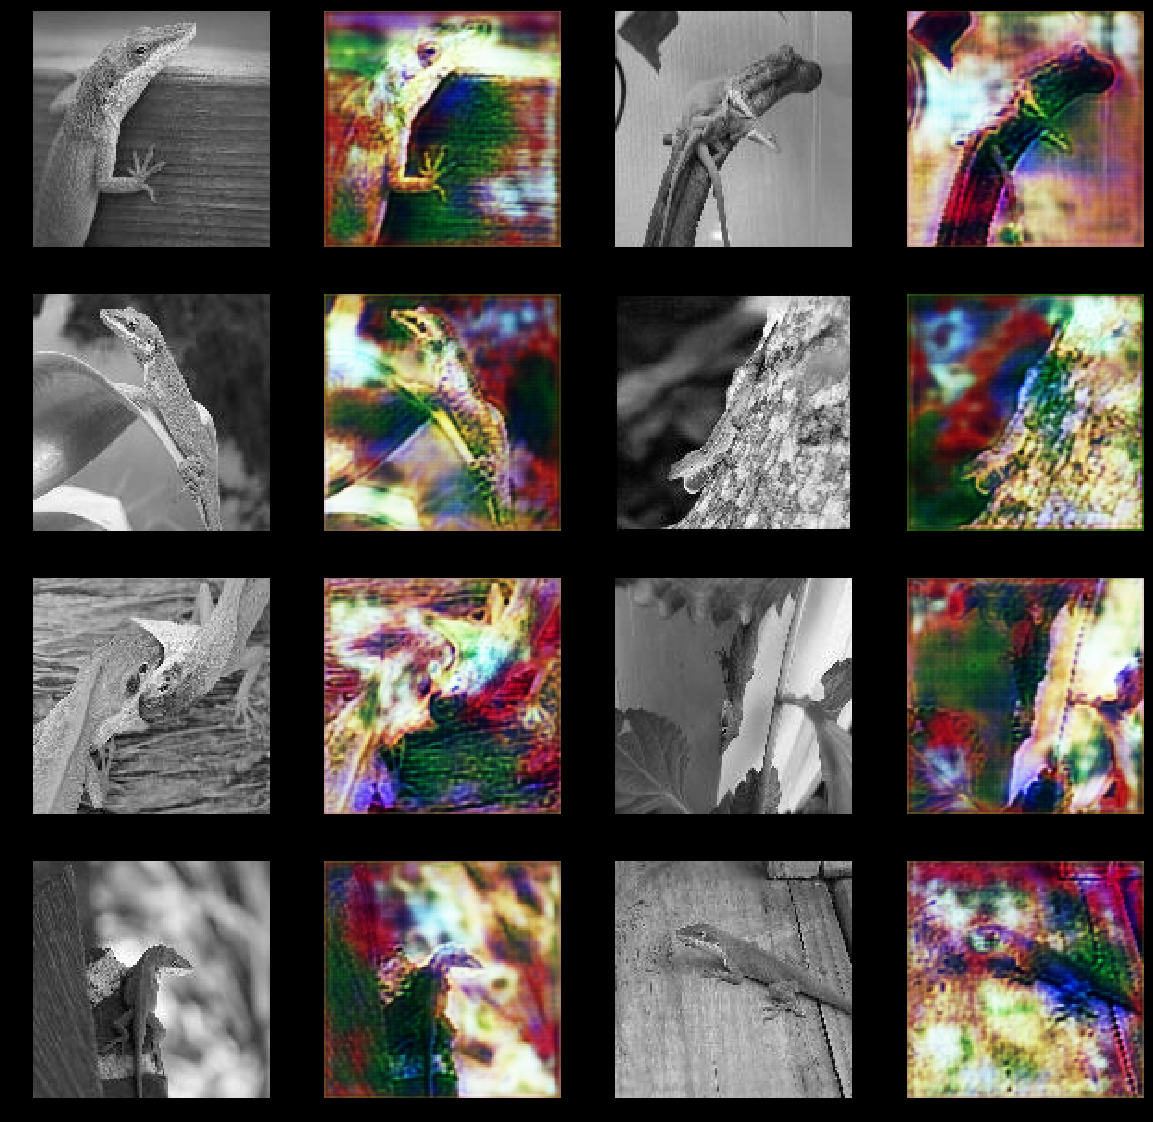

  4%|▍         | 3019/79264 [35:42<14:20:28,  1.48it/s]
WDist -29672.275390625; GPenalty 11026.583984375; RScore 14272.84375; FScore -15399.431640625; Equilibrium? Y
  4%|▍         | 3049/79264 [36:03<14:17:46,  1.48it/s]
WDist -34917.1953125; GPenalty 20826.083984375; RScore 17132.796875; FScore -17784.400390625; Equilibrium? Y
  4%|▍         | 3050/79264 [36:04<15:57:22,  1.33it/s]
WDist -6548.13671875; GPenalty 11072.4140625; RScore 17420.373046875; FScore 10872.236328125; Equilibrium? N
  4%|▍         | 3065/79264 [36:14<14:20:13,  1.48it/s]
WDist -34750.51953125; GPenalty 15200.9296875; RScore 17307.390625; FScore -17443.12890625; Equilibrium? Y
  4%|▍         | 3066/79264 [36:15<16:01:25,  1.32it/s]
WDist -19182.30078125; GPenalty 19255.53515625; RScore 9571.740234375; FScore -9610.560546875; Equilibrium? Y
  4%|▍         | 3100/79264 [36:39<14:16:50,  1.48it/s]
WDist -27900.57421875; GPenalty 10014.58203125; RScore 18274.833984375; FScore -9625.7412109375; Equilibrium? N
  4%|▍ 

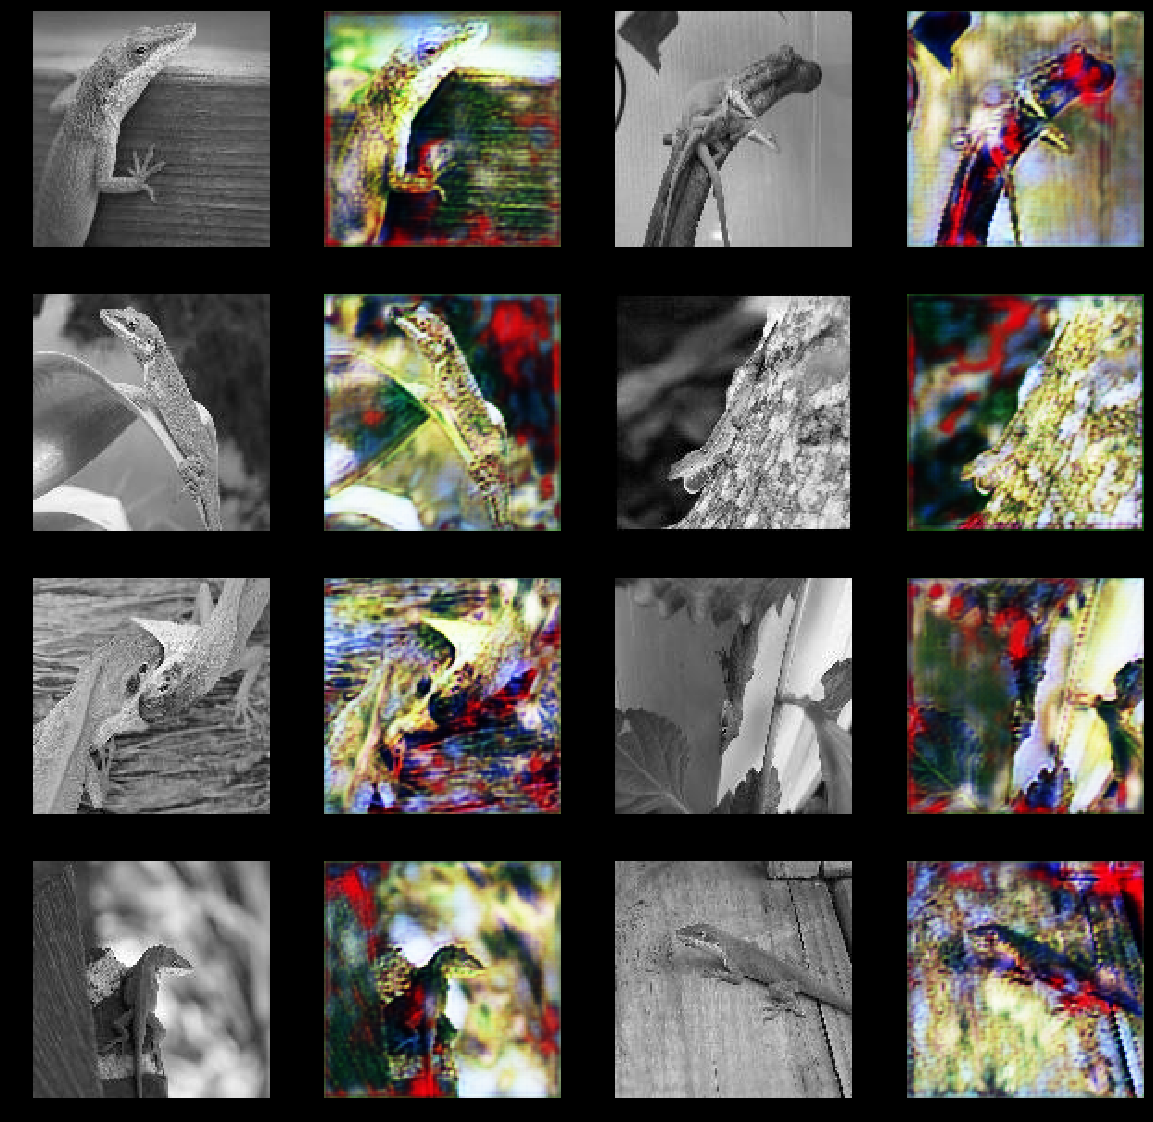

  4%|▍         | 3550/79264 [41:58<14:13:11,  1.48it/s]
WDist -32820.765625; GPenalty 13044.7578125; RScore 1618.2044677734375; FScore -31202.5625; Equilibrium? N
  5%|▍         | 3600/79264 [42:31<14:10:45,  1.48it/s]
WDist -33566.1640625; GPenalty 18443.724609375; RScore 8811.7412109375; FScore -24754.421875; Equilibrium? N
  5%|▍         | 3619/79264 [42:44<14:11:28,  1.48it/s]
WDist -35232.890625; GPenalty 10579.291015625; RScore 17275.642578125; FScore -17957.24609375; Equilibrium? Y
  5%|▍         | 3625/79264 [42:49<14:26:36,  1.45it/s]
WDist -56254.4765625; GPenalty 39950.53125; RScore 29068.728515625; FScore -27185.74609375; Equilibrium? Y
  5%|▍         | 3650/79264 [43:06<14:10:46,  1.48it/s]
WDist -17780.017578125; GPenalty 4950.6240234375; RScore -20671.548828125; FScore -38451.56640625; Equilibrium? N
  5%|▍         | 3668/79264 [43:18<14:11:13,  1.48it/s]
WDist -51717.5546875; GPenalty 14757.4912109375; RScore 24852.130859375; FScore -26865.421875; Equilibrium? Y
  5%|▍ 

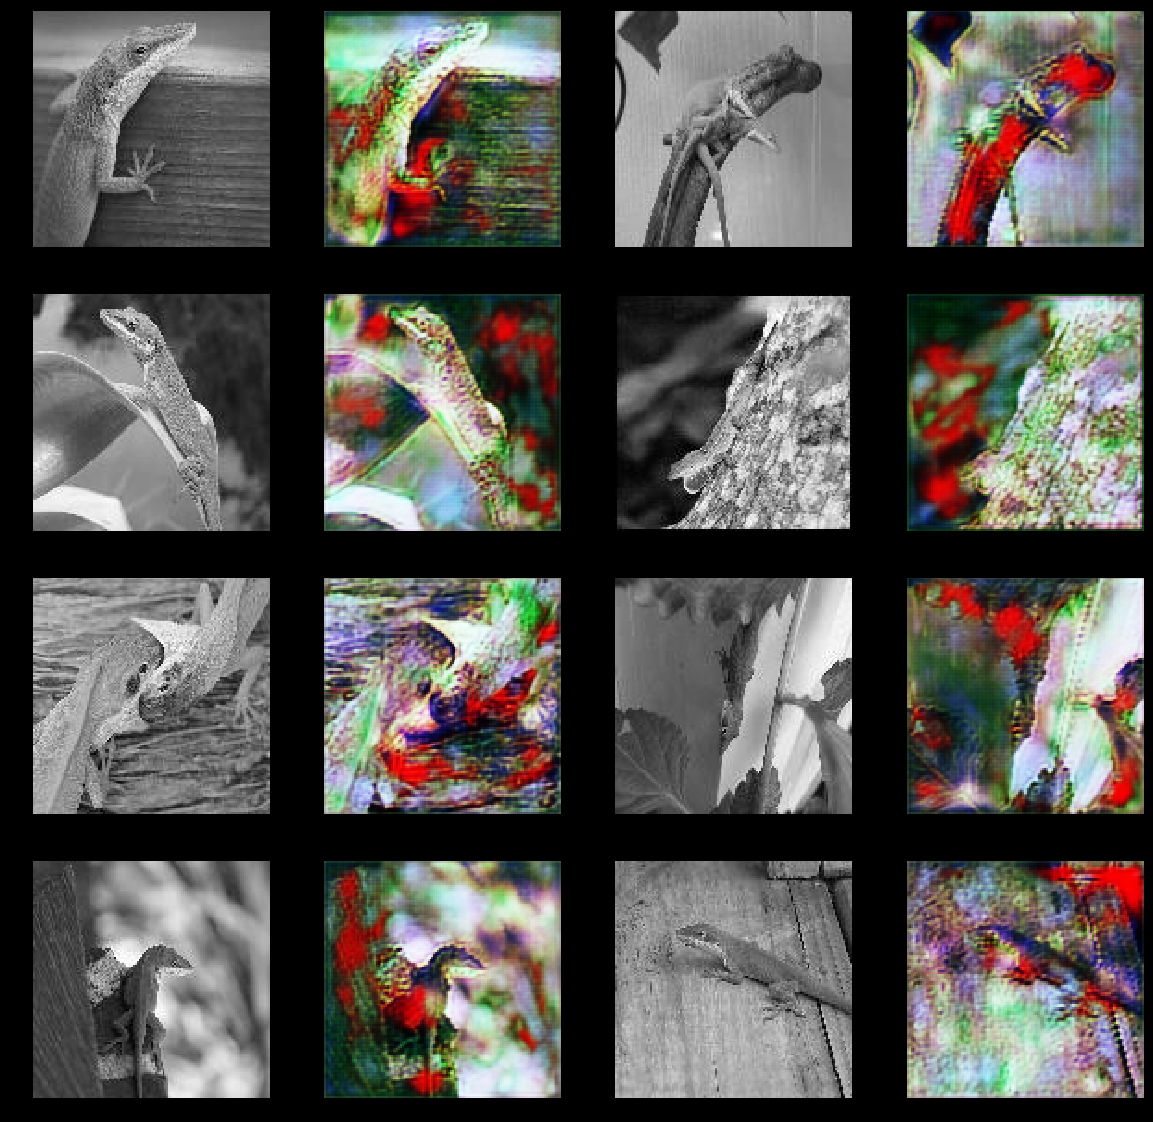

  5%|▌         | 4050/79264 [47:52<14:06:54,  1.48it/s]
WDist -44426.70703125; GPenalty 16925.10546875; RScore 16019.318359375; FScore -28407.388671875; Equilibrium? N
  5%|▌         | 4096/79264 [48:23<14:05:21,  1.48it/s]
WDist -65681.1484375; GPenalty 27809.703125; RScore 32676.755859375; FScore -33004.390625; Equilibrium? Y
  5%|▌         | 4100/79264 [48:26<14:40:04,  1.42it/s]
WDist -37755.703125; GPenalty 14429.875; RScore -2588.512451171875; FScore -40344.21484375; Equilibrium? N
  5%|▌         | 4133/79264 [48:48<14:06:00,  1.48it/s]
WDist -51732.4453125; GPenalty 27234.044921875; RScore 25839.775390625; FScore -25892.671875; Equilibrium? Y
  5%|▌         | 4150/79264 [49:00<14:07:47,  1.48it/s]
WDist -55778.578125; GPenalty 25217.01171875; RScore 18867.275390625; FScore -36911.30078125; Equilibrium? N
  5%|▌         | 4181/79264 [49:22<14:07:02,  1.48it/s]
WDist -50479.16796875; GPenalty 57360.90234375; RScore 25307.421875; FScore -25171.74609375; Equilibrium? Y
  5%|▌       

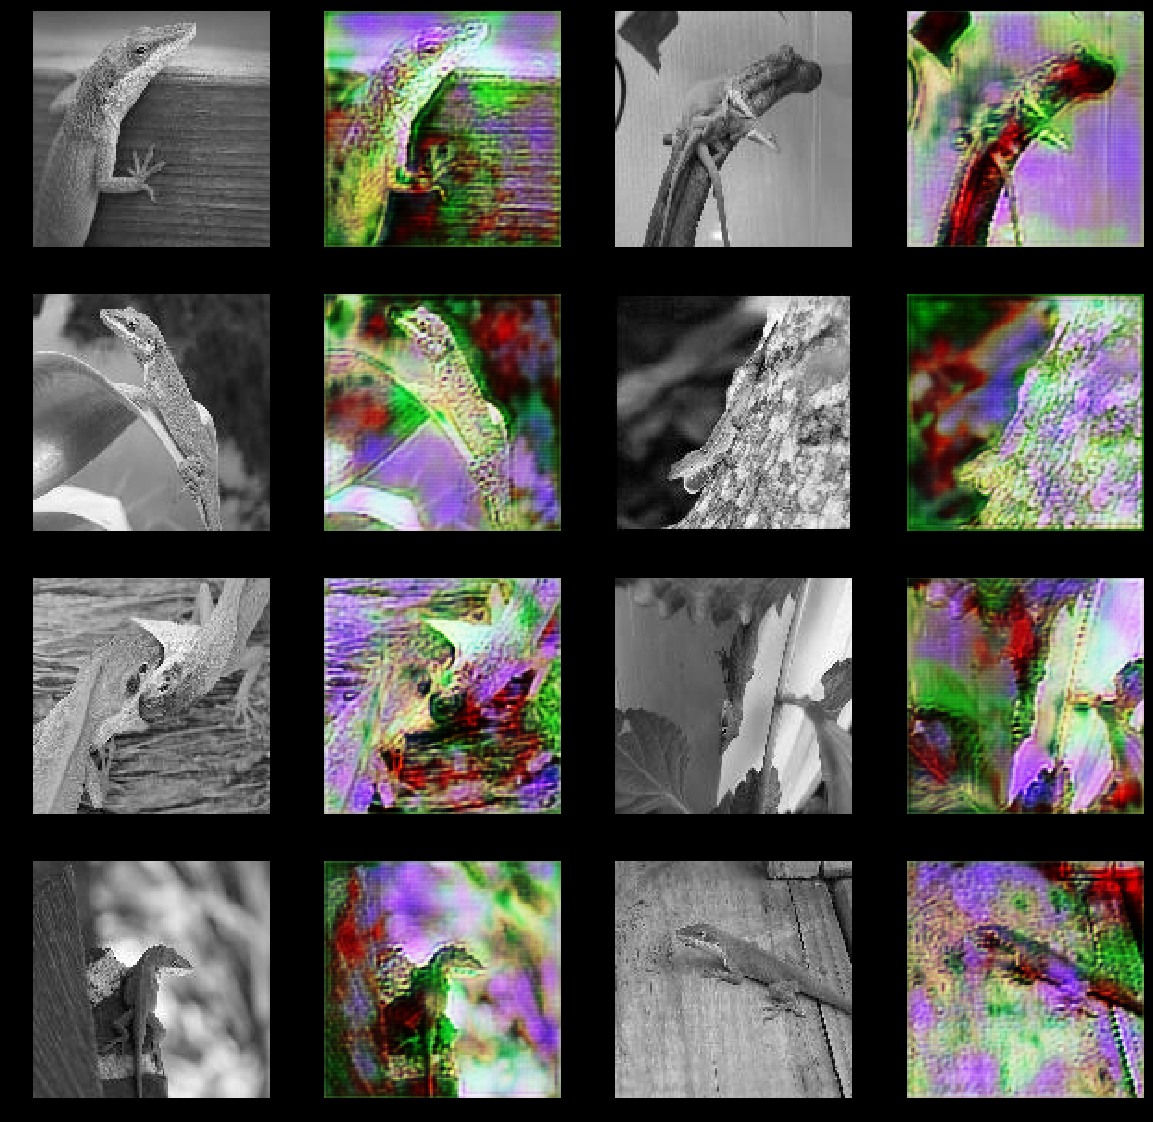

  6%|▌         | 4513/79264 [53:35<16:02:15,  1.29it/s]
WDist -57205.2109375; GPenalty 36352.34765625; RScore 27294.07421875; FScore -29911.138671875; Equilibrium? Y
  6%|▌         | 4550/79264 [54:00<13:59:46,  1.48it/s]
WDist -43331.2109375; GPenalty 20282.955078125; RScore -7561.4931640625; FScore -50892.703125; Equilibrium? N
  6%|▌         | 4573/79264 [54:15<13:59:03,  1.48it/s]
WDist -56197.50390625; GPenalty 28488.80859375; RScore 27131.1953125; FScore -29066.30859375; Equilibrium? Y
  6%|▌         | 4587/79264 [54:25<14:00:39,  1.48it/s]
WDist -62387.6796875; GPenalty 40227.98046875; RScore 31141.818359375; FScore -31245.86328125; Equilibrium? Y
  6%|▌         | 4600/79264 [54:34<14:01:06,  1.48it/s]
WDist -38988.01953125; GPenalty 17635.603515625; RScore -354.84747314453125; FScore -39342.8671875; Equilibrium? N
  6%|▌         | 4650/79264 [55:09<14:02:19,  1.48it/s]
WDist -37072.765625; GPenalty 8427.498046875; RScore -8086.263671875; FScore -45159.02734375; Equilibrium? N
 

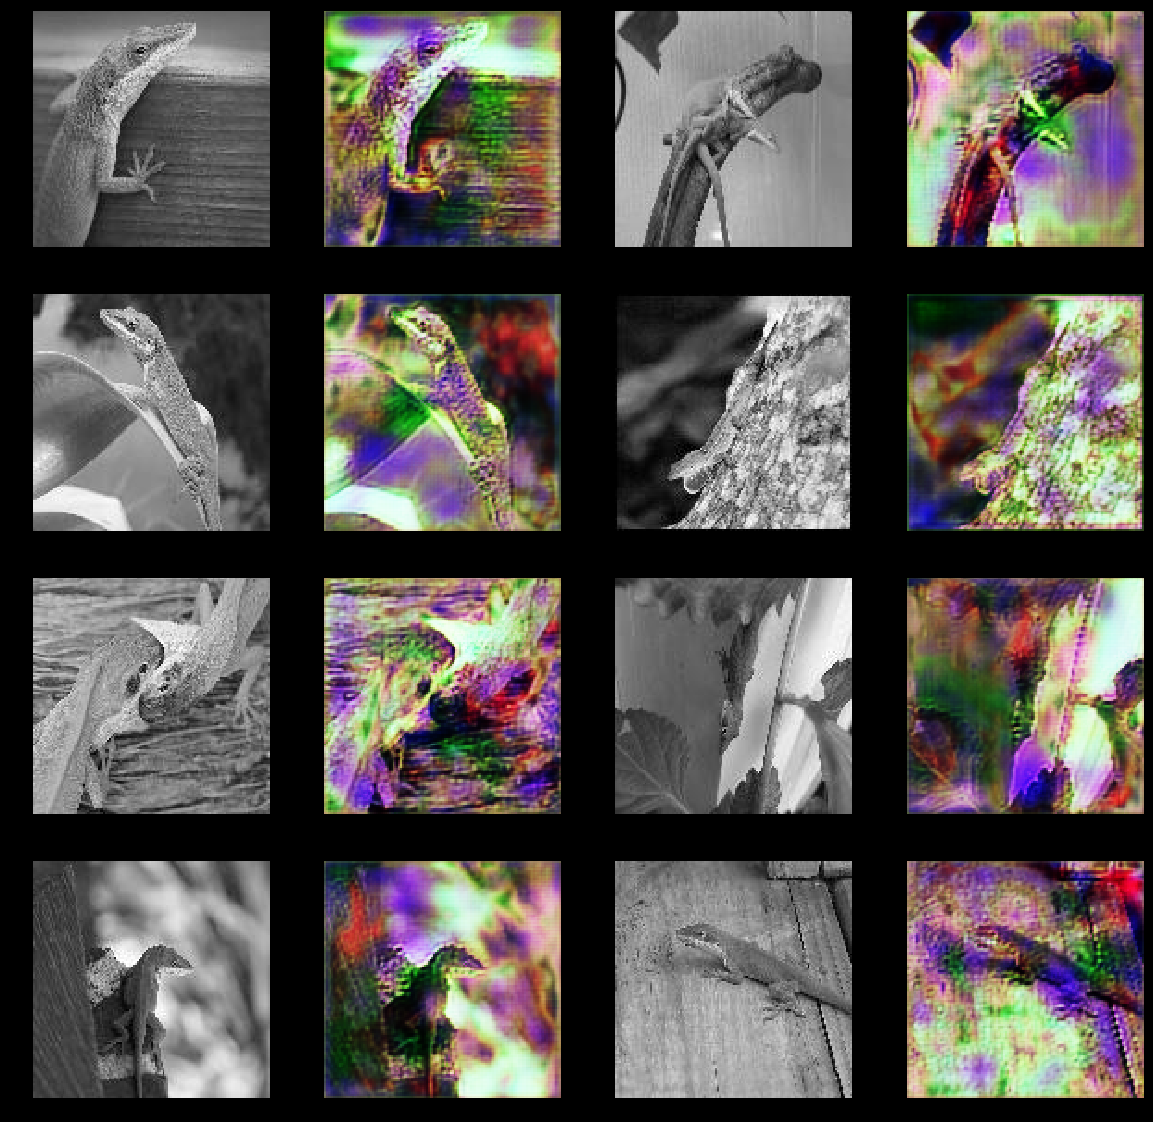

  6%|▋         | 5050/79264 [59:45<13:54:46,  1.48it/s]
WDist -55153.625; GPenalty 26767.55859375; RScore 14670.3193359375; FScore -40483.3046875; Equilibrium? N
  6%|▋         | 5100/79264 [1:00:19<13:57:38,  1.48it/s]
WDist -40802.3125; GPenalty 7989.43603515625; RScore -10650.451171875; FScore -51452.765625; Equilibrium? N
  6%|▋         | 5150/79264 [1:00:54<13:52:42,  1.48it/s]
WDist -44047.23828125; GPenalty 16791.375; RScore -152.35533142089844; FScore -44199.59375; Equilibrium? N
  7%|▋         | 5200/79264 [1:01:28<13:53:52,  1.48it/s]
WDist -57386.81640625; GPenalty 18331.853515625; RScore 9961.0791015625; FScore -47425.73828125; Equilibrium? N
  7%|▋         | 5213/79264 [1:01:37<13:54:20,  1.48it/s]

In [ ]:
train(1, True)
#train(1, False)

In [ ]:
train(9, False)